# NeuroBook

In [153]:
%pip install mne

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [154]:
import mne
import numpy as np
import pandas as pd

## Data Loading and Inspection 

In [155]:
path = '../Datasets/EEG_data_BRMH.csv'
input= pd.read_csv(path)
input.info()
input

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB


,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [156]:
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}

## Data Loading and Inspection 

In [157]:
input.describe()

,no.,age,education,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,945.000000,945.000000,930.000000,932.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,...,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,473.000000,30.594804,13.438710,101.580472,20.182936,21.177584,17.749553,18.901698,20.447079,19.490329,...,75.889633,55.049113,56.959796,60.739169,69.829254,47.862489,66.832798,39.301406,66.153213,57.056207
std,272.942302,11.781592,2.550461,17.022414,11.282022,12.230662,10.003598,9.079482,9.742912,9.252500,...,15.861641,19.541956,18.326785,18.052887,17.725321,19.685722,17.028701,20.790933,18.088548,19.600107
min,1.000000,18.000000,0.000000,49.000000,3.272260,3.244199,3.050507,3.412618,5.066593,4.048931,...,12.611954,0.519048,6.926792,0.708008,2.421748,0.036664,1.032207,1.228502,0.363268,3.988805
25%,237.000000,21.730000,12.000000,91.000000,12.784872,13.019269,11.134327,12.460586,13.548645,12.637717,...,68.014443,41.607506,43.682444,48.374883,58.937785,32.581046,55.872070,22.049743,54.710605,43.955229
50%,473.000000,26.150000,13.000000,102.000000,17.065286,17.838251,15.541469,16.733004,18.065276,17.432568,...,78.647712,55.158858,56.657348,61.257972,72.298636,45.719426,68.238375,36.549938,67.988937,57.515871
75%,709.000000,35.450000,16.000000,114.000000,24.492760,25.654394,21.623961,23.347900,25.573096,23.956748,...,87.398387,69.740640,70.649245,73.979100,83.066877,62.081839,79.192418,54.169209,79.527764,71.626382
max,945.000000,71.880000,20.000000,145.000000,92.826192,101.515687,91.373456,82.544167,101.566662,77.197502,...,99.678649,100.000000,99.307895,100.000000,99.581629,98.720067,99.650154,98.413320,100.000000,99.287092


## Cleaning and Preprocessing

In [158]:
ptsd = input[input['specific.disorder'] == 'Posttraumatic stress disorder']
hc = input[input['specific.disorder'] == 'Healthy control'].sample(n=52, random_state=42)
data = pd.concat([ptsd, hc])
data

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
297,298,F,36.62,2011.1.28,12.0,99.0,Trauma and stress related disorder,Posttraumatic stress disorder,17.603385,17.243334,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
309,310,F,55.21,2012.4.9,16.0,120.0,Trauma and stress related disorder,Posttraumatic stress disorder,21.714048,19.579805,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
310,311,F,26.93,2011.3.24,16.0,116.0,Trauma and stress related disorder,Posttraumatic stress disorder,13.371076,14.028142,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
315,316,M,26.71,2012.7.3,17.0,137.0,Trauma and stress related disorder,Posttraumatic stress disorder,30.473244,13.954586,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
318,319,F,23.45,2014.6.2,12.0,89.0,Trauma and stress related disorder,Posttraumatic stress disorder,18.488575,19.603144,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,138,F,29.04,2018.8.9,16.0,114.0,Healthy control,Healthy control,22.737005,23.110192,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
116,117,F,25.65,2018.7.2,18.0,118.0,Healthy control,Healthy control,20.081892,17.928614,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
130,131,F,29.86,2018.7.19,20.0,113.0,Healthy control,Healthy control,46.306229,47.379694,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
184,185,M,27.00,2017.4.29,18.0,130.0,Healthy control,Healthy control,22.152399,22.698280,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [159]:
data.drop('no.', axis=1, inplace=True)
data.drop('eeg.date', axis=1, inplace=True)
data.drop('main.disorder', axis=1, inplace=True)
data.drop('education', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data.drop('index', axis=1, errors='ignore')
data.index = range(1, len(data) + 1)
data

,sex,age,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
1,F,36.62,99.0,Posttraumatic stress disorder,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,F,55.21,120.0,Posttraumatic stress disorder,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,F,26.93,116.0,Posttraumatic stress disorder,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,M,26.71,137.0,Posttraumatic stress disorder,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,F,23.45,89.0,Posttraumatic stress disorder,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,F,25.65,118.0,Healthy control,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,F,29.86,113.0,Healthy control,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,M,27.00,130.0,Healthy control,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [160]:
data 

,sex,age,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
1,F,36.62,99.0,Posttraumatic stress disorder,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,F,55.21,120.0,Posttraumatic stress disorder,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,F,26.93,116.0,Posttraumatic stress disorder,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,M,26.71,137.0,Posttraumatic stress disorder,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,F,23.45,89.0,Posttraumatic stress disorder,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,F,25.65,118.0,Healthy control,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,F,29.86,113.0,Healthy control,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,M,27.00,130.0,Healthy control,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [161]:
data.columns = data.columns.str.strip().str.lower()
print(data.columns)

Index(['sex', 'age', 'iq', 'specific.disorder', 'ab.a.delta.a.fp1',
       'ab.a.delta.b.fp2', 'ab.a.delta.c.f7', 'ab.a.delta.d.f3',
       'ab.a.delta.e.fz', 'ab.a.delta.f.f4',
       ...
       'coh.f.gamma.o.pz.p.p4', 'coh.f.gamma.o.pz.q.t6',
       'coh.f.gamma.o.pz.r.o1', 'coh.f.gamma.o.pz.s.o2',
       'coh.f.gamma.p.p4.q.t6', 'coh.f.gamma.p.p4.r.o1',
       'coh.f.gamma.p.p4.s.o2', 'coh.f.gamma.q.t6.r.o1',
       'coh.f.gamma.q.t6.s.o2', 'coh.f.gamma.r.o1.s.o2'],
      dtype='object', length=1145)


In [162]:
data['iq'] = data['iq'].astype('float64')
data['specific.disorder'] = data['specific.disorder'].astype('category')
data['sex'] = data['sex'].astype('category')

print(data.dtypes.head())  

sex                  category
age                   float64
iq                    float64
specific.disorder    category
ab.a.delta.a.fp1      float64
dtype: object


In [163]:
separator = data.columns.get_loc(data.columns[data.isnull().all()][0])
separator

118

In [164]:
AB_data = data.iloc[:,:separator]
AB_data

,sex,age,iq,specific.disorder,ab.a.delta.a.fp1,ab.a.delta.b.fp2,ab.a.delta.c.f7,ab.a.delta.d.f3,ab.a.delta.e.fz,ab.a.delta.f.f4,...,ab.f.gamma.j.cz,ab.f.gamma.k.c4,ab.f.gamma.l.t4,ab.f.gamma.m.t5,ab.f.gamma.n.p3,ab.f.gamma.o.pz,ab.f.gamma.p.p4,ab.f.gamma.q.t6,ab.f.gamma.r.o1,ab.f.gamma.s.o2
1,F,36.62,99.0,Posttraumatic stress disorder,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,0.711707,0.700034,1.109298,0.775247,0.909426,0.721567,0.794328,0.728853,0.745882,0.818206
2,F,55.21,120.0,Posttraumatic stress disorder,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,0.505744,0.625066,0.334231,0.296254,0.394191,0.435409,0.410746,0.281834,0.334405,0.318448
3,F,26.93,116.0,Posttraumatic stress disorder,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,1.271004,1.024326,0.400827,0.282066,0.571112,0.673131,0.885947,0.381586,0.417947,0.333066
4,M,26.71,137.0,Posttraumatic stress disorder,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,1.154785,1.387544,0.969391,2.290670,2.323228,0.853186,0.936312,0.895048,10.464573,1.541601
5,F,23.45,89.0,Posttraumatic stress disorder,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,2.714135,1.949369,1.142552,1.389620,1.369314,1.441666,1.420502,0.580418,2.445275,0.880921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,1.475588,1.859906,1.330466,1.224385,1.722680,1.863039,2.212353,1.571332,1.974860,7.184206
101,F,25.65,118.0,Healthy control,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,1.179378,0.938444,0.652126,0.874891,0.800209,0.911272,0.823876,0.676607,0.654119,0.682812
102,F,29.86,113.0,Healthy control,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,4.111914,3.574915,2.186331,2.229601,3.350566,3.561434,3.087733,2.223389,2.907973,2.761723
103,M,27.00,130.0,Healthy control,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,1.661193,1.474120,1.269868,1.410183,1.487806,1.530798,1.531705,1.553039,1.733781,2.511217


In [165]:
COH_data = data.iloc[:, list(range(4)) + list(range(separator+1 , data.shape[1]))]
COH_data

,sex,age,iq,specific.disorder,coh.a.delta.a.fp1.b.fp2,coh.a.delta.a.fp1.c.f7,coh.a.delta.a.fp1.d.f3,coh.a.delta.a.fp1.e.fz,coh.a.delta.a.fp1.f.f4,coh.a.delta.a.fp1.g.f8,...,coh.f.gamma.o.pz.p.p4,coh.f.gamma.o.pz.q.t6,coh.f.gamma.o.pz.r.o1,coh.f.gamma.o.pz.s.o2,coh.f.gamma.p.p4.q.t6,coh.f.gamma.p.p4.r.o1,coh.f.gamma.p.p4.s.o2,coh.f.gamma.q.t6.r.o1,coh.f.gamma.q.t6.s.o2,coh.f.gamma.r.o1.s.o2
1,F,36.62,99.0,Posttraumatic stress disorder,80.375130,22.109628,83.707393,80.704111,65.231645,39.669620,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,F,55.21,120.0,Posttraumatic stress disorder,99.699970,60.286374,78.790309,71.929308,66.957990,32.227674,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,F,26.93,116.0,Posttraumatic stress disorder,88.131324,77.536120,82.648529,73.620037,72.210662,59.191032,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,M,26.71,137.0,Posttraumatic stress disorder,69.998866,64.997577,78.672407,70.866896,54.415283,27.894286,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,F,23.45,89.0,Posttraumatic stress disorder,60.305588,58.643782,65.075301,56.065351,49.836470,25.962092,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,54.615410,51.608236,61.993370,57.373808,38.864399,4.053128,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,F,25.65,118.0,Healthy control,90.006558,99.877118,99.868472,99.707290,69.565596,69.483540,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,F,29.86,113.0,Healthy control,26.770053,23.884052,36.898819,37.190457,37.182856,4.849569,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,M,27.00,130.0,Healthy control,51.903003,99.701376,99.778920,78.109412,78.079135,64.240750,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [166]:
data

,sex,age,iq,specific.disorder,ab.a.delta.a.fp1,ab.a.delta.b.fp2,ab.a.delta.c.f7,ab.a.delta.d.f3,ab.a.delta.e.fz,ab.a.delta.f.f4,...,coh.f.gamma.o.pz.p.p4,coh.f.gamma.o.pz.q.t6,coh.f.gamma.o.pz.r.o1,coh.f.gamma.o.pz.s.o2,coh.f.gamma.p.p4.q.t6,coh.f.gamma.p.p4.r.o1,coh.f.gamma.p.p4.s.o2,coh.f.gamma.q.t6.r.o1,coh.f.gamma.q.t6.s.o2,coh.f.gamma.r.o1.s.o2
1,F,36.62,99.0,Posttraumatic stress disorder,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,F,55.21,120.0,Posttraumatic stress disorder,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,F,26.93,116.0,Posttraumatic stress disorder,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,M,26.71,137.0,Posttraumatic stress disorder,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,F,23.45,89.0,Posttraumatic stress disorder,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,F,25.65,118.0,Healthy control,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,F,29.86,113.0,Healthy control,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,M,27.00,130.0,Healthy control,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [167]:
data.isnull().sum().sum()

104

## Classification

In [168]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, precision_score

def evaluate_model(model, x, y_true):
    y_pred = model.predict(x)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred)
    }

In [169]:
def classify(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    return evaluate_model(model, X_test, y_test)

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [171]:
le=LabelEncoder()
data=data.drop(columns='unnamed: 122')
data['specific.disorder'] = data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
data['sex']= le.fit_transform(data['sex'])
X = data.drop('specific.disorder', axis=1) 
y = data['specific.disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
data 

,sex,age,iq,specific.disorder,ab.a.delta.a.fp1,ab.a.delta.b.fp2,ab.a.delta.c.f7,ab.a.delta.d.f3,ab.a.delta.e.fz,ab.a.delta.f.f4,...,coh.f.gamma.o.pz.q.t6,coh.f.gamma.o.pz.r.o1,coh.f.gamma.o.pz.s.o2,coh.f.gamma.p.p4.q.t6,coh.f.gamma.p.p4.r.o1,coh.f.gamma.p.p4.s.o2,coh.f.gamma.q.t6.r.o1,coh.f.gamma.q.t6.s.o2,coh.f.gamma.r.o1.s.o2,Outlier
1,0,36.62,99.0,1,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767,1
2,0,55.21,120.0,1,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439,1
3,0,26.93,116.0,1,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464,1
4,1,26.71,137.0,1,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506,1
5,0,23.45,89.0,1,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0,29.04,114.0,0,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645,1
101,0,25.65,118.0,0,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496,1
102,0,29.86,113.0,0,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560,-1
103,1,27.00,130.0,0,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626,1


In [ ]:
X_train.head(), y_train.head()

(     sex    age     iq  ab.a.delta.a.fp1  ab.a.delta.b.fp2  ab.a.delta.c.f7  \
 104    0  23.66  130.0         37.450821         54.405099        24.135037   
 79     1  25.00  115.0         34.108015         22.838567        20.646824   
 29     0  57.78   97.0          8.633226          8.842760         9.890202   
 80     1  28.00  134.0         14.581102         14.033041        13.906960   
 6      0  33.97  101.0          5.321305          5.468460         4.137321   
 
      ab.a.delta.d.f3  ab.a.delta.e.fz  ab.a.delta.f.f4  ab.a.delta.g.f8  ...  \
 104        22.605822        23.746038        25.139759        33.146333  ...   
 79         18.203362        17.361846        16.311194        23.092874  ...   
 29         15.020229        17.821645        15.300829         6.833061  ...   
 80         13.086081        12.722494         9.104962         8.377018  ...   
 6           5.126773         5.348178         5.482973         5.119691  ...   
 
      coh.f.gamma.o.pz.p.p4  c

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)

classify(logistic_regression, X_train, y_train, X_test, y_test)

{'Accuracy': 0.625,
 'Precision': 0.65,
 'Recall': 0.7222222222222222,
 'F1 Score': 0.6842105263157895,
 'Confusion Matrix': array([[ 7,  7],
        [ 5, 13]])}

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

classify(random_forest, X_train, y_train, X_test, y_test)

{'Accuracy': 0.78125,
 'Precision': 0.8235294117647058,
 'Recall': 0.7777777777777778,
 'F1 Score': 0.7999999999999999,
 'Confusion Matrix': array([[11,  3],
        [ 4, 14]])}

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state=42)

classify(svm, X_train, y_train, X_test, y_test)

{'Accuracy': 0.6875,
 'Precision': 0.75,
 'Recall': 0.6666666666666666,
 'F1 Score': 0.7058823529411765,
 'Confusion Matrix': array([[10,  4],
        [ 6, 12]])}

## AB Data

In [ ]:
data = pd.read_csv("data.csv")
AB_data = data.filter(like='ab', axis=1)

In [ ]:
AB_data=AB_data.drop(columns=['sex','age','iq'])
AB_data['specific.disorder'] = AB_data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
X = AB_data.drop('specific.disorder', axis=1) 
y = AB_data['specific.disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)

classify(logistic_regression, X_train, y_train, X_test, y_test)

{'Accuracy': 0.71875,
 'Precision': 0.7647058823529411,
 'Recall': 0.7222222222222222,
 'F1 Score': 0.7428571428571428,
 'Confusion Matrix': array([[10,  4],
        [ 5, 13]])}

##### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

classify(random_forest, X_train, y_train, X_test, y_test)

{'Accuracy': 0.59375,
 'Precision': 0.7272727272727273,
 'Recall': 0.4444444444444444,
 'F1 Score': 0.5517241379310345,
 'Confusion Matrix': array([[11,  3],
        [10,  8]])}

##### SVC

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state=42)

classify(svm, X_train, y_train, X_test, y_test)

{'Accuracy': 0.59375,
 'Precision': 0.7777777777777778,
 'Recall': 0.3888888888888889,
 'F1 Score': 0.5185185185185185,
 'Confusion Matrix': array([[12,  2],
        [11,  7]])}

##### elasticnet

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming you have the classify function defined, similar to the one used for Logistic Regression and Random Forest
elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, max_iter=10000)

classify(elastic_net, X_train, y_train, X_test, y_test)


{'Accuracy': 0.625,
 'Precision': 0.6363636363636364,
 'Recall': 0.7777777777777778,
 'F1 Score': 0.7000000000000001,
 'Confusion Matrix': array([[ 6,  8],
        [ 4, 14]], dtype=int64)}

##### linear_svc

In [ ]:
from sklearn.svm import SVC

# Instantiate SVC with a linear kernel
linear_svc = SVC(kernel='linear', random_state=42)

# Assuming you have a classify function as with other models
classify(linear_svc, X_train, y_train, X_test, y_test)


{'Accuracy': 0.59375,
 'Precision': 0.631578947368421,
 'Recall': 0.6666666666666666,
 'F1 Score': 0.6486486486486486,
 'Confusion Matrix': array([[ 7,  7],
        [ 6, 12]], dtype=int64)}

##### xgboost

In [ ]:
from xgboost import XGBClassifier

# Instantiate XGBClassifier with a specified random state for reproducibility
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Assuming you have a classify function as with other models
classify(xgboost_model, X_train, y_train, X_test, y_test)


C:\Users\DARSHAN PARMAR\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [02:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'Accuracy': 0.84375,
 'Precision': 0.9333333333333333,
 'Recall': 0.7777777777777778,
 'F1 Score': 0.8484848484848485,
 'Confusion Matrix': array([[13,  1],
        [ 4, 14]], dtype=int64)}

##### lightgbm

In [ ]:
from lightgbm import LGBMClassifier

# Instantiate LGBMClassifier with a specified random state for reproducibility
lightgbm_model = LGBMClassifier(random_state=42)

# Assuming you have a classify function as with other models
classify(lightgbm_model, X_train, y_train, X_test, y_test)


[LightGBM] [Info] Number of positive: 34, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28545
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

{'Accuracy': 0.84375,
 'Precision': 0.9333333333333333,
 'Recall': 0.7777777777777778,
 'F1 Score': 0.8484848484848485,
 'Confusion Matrix': array([[13,  1],
        [ 4, 14]], dtype=int64)}

##### catboost

In [ ]:
from catboost import CatBoostClassifier

# Instantiate CatBoostClassifier with basic settings and a specified random state
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)

# Assuming you have a classify function as with other models
classify(catboost_model, X_train, y_train, X_test, y_test)


{'Accuracy': 0.84375,
 'Precision': 0.8823529411764706,
 'Recall': 0.8333333333333334,
 'F1 Score': 0.8571428571428571,
 'Confusion Matrix': array([[12,  2],
        [ 3, 15]], dtype=int64)}

In [173]:


# Define the classify function to calculate and store accuracy
def classify_and_store_results(model, model_name, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy})

# Split your data (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List to store the results of each model
results = []

# Instantiate each model and store the accuracy results
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)
classify_and_store_results(logistic_regression, "Logistic Regression", X_train, y_train, X_test, y_test, results)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
classify_and_store_results(random_forest, "Random Forest", X_train, y_train, X_test, y_test, results)

svm = SVC(kernel='linear', random_state=42)
classify_and_store_results(svm, "Linear SVM", X_train, y_train, X_test, y_test, results)

xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
classify_and_store_results(xgboost_model, "XGBoost", X_train, y_train, X_test, y_test, results)

lightgbm_model = LGBMClassifier(random_state=42)
classify_and_store_results(lightgbm_model, "LightGBM", X_train, y_train, X_test, y_test, results)

catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
classify_and_store_results(catboost_model, "CatBoost", X_train, y_train, X_test, y_test, results)

# Convert the results list to a DataFrame for a table format
results_df = pd.DataFrame(results)

# Display the results table
print("Comparison of Model Accuracies:")
print(results_df)

# Conclusion based on the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nConclusion: The best model is {best_model['Model']} with an accuracy of {best_model['Accuracy']:.2f}")

import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for a cleaner output


C:\Users\DARSHAN PARMAR\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 34, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28545
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

## COH Data

In [ ]:
COH_data = data.filter(like='coh', axis=1)

In [ ]:
COH_data=COH_data.drop(columns=['sex','age','iq'])
COH_data['specific.disorder'] = COH_data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
X = data.drop('specific.disorder', axis=1) 
y = COH_data['specific.disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)

classify(logistic_regression, X_train, y_train, X_test, y_test)

{'Accuracy': 0.625,
 'Precision': 0.65,
 'Recall': 0.7222222222222222,
 'F1 Score': 0.6842105263157895,
 'Confusion Matrix': array([[ 7,  7],
        [ 5, 13]], dtype=int64)}

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

classify(random_forest, X_train, y_train, X_test, y_test)

{'Accuracy': 0.6875,
 'Precision': 0.7857142857142857,
 'Recall': 0.6111111111111112,
 'F1 Score': 0.6875000000000001,
 'Confusion Matrix': array([[11,  3],
        [ 7, 11]])}

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state=42)

classify(svm, X_train, y_train, X_test, y_test)

{'Accuracy': 0.6875,
 'Precision': 0.75,
 'Recall': 0.6666666666666666,
 'F1 Score': 0.7058823529411765,
 'Confusion Matrix': array([[10,  4],
        [ 6, 12]])}

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for a cleaner output

# Assuming COH_data is already loaded, preprocessing it as described
COH_data = COH_data.drop(columns=['sex', 'age', 'iq'])
COH_data['specific.disorder'] = COH_data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})

# Features and target variable
X = COH_data.drop('specific.disorder', axis=1)
y = COH_data['specific.disorder']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the classify function to calculate and store accuracy
def classify_and_store_results(model, model_name, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy})

# List to store the results of each model
results = []

# Logistic Regression
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)
classify_and_store_results(logistic_regression, "Logistic Regression", X_train, y_train, X_test, y_test, results)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
classify_and_store_results(random_forest, "Random Forest", X_train, y_train, X_test, y_test, results)

# Elastic Net
elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, max_iter=10000)
classify_and_store_results(elastic_net, "Elastic Net", X_train, y_train, X_test, y_test, results)

# Linear Kernel SVC
linear_svc = SVC(kernel='linear', random_state=42)
classify_and_store_results(linear_svc, "Linear SVM", X_train, y_train, X_test, y_test, results)

# XGBoost
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
classify_and_store_results(xgboost_model, "XGBoost", X_train, y_train, X_test, y_test, results)

# LightGBM
lightgbm_model = LGBMClassifier(random_state=42)
classify_and_store_results(lightgbm_model, "LightGBM", X_train, y_train, X_test, y_test, results)

# CatBoost
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
classify_and_store_results(catboost_model, "CatBoost", X_train, y_train, X_test, y_test, results)

# Convert the results list to a DataFrame for a table format
results_df = pd.DataFrame(results)

# Display the results table in a formatted way
print("Comparison of Model Accuracies:\n")
print(results_df.to_string(index=False))

# Conclusion based on the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nConclusion: The best model is **{best_model['Model']}** with an accuracy of {best_model['Accuracy']:.2%}")


[LightGBM] [Info] Number of positive: 34, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25650
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1026
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

# Feature importance

##### Generate head picture for visualisations

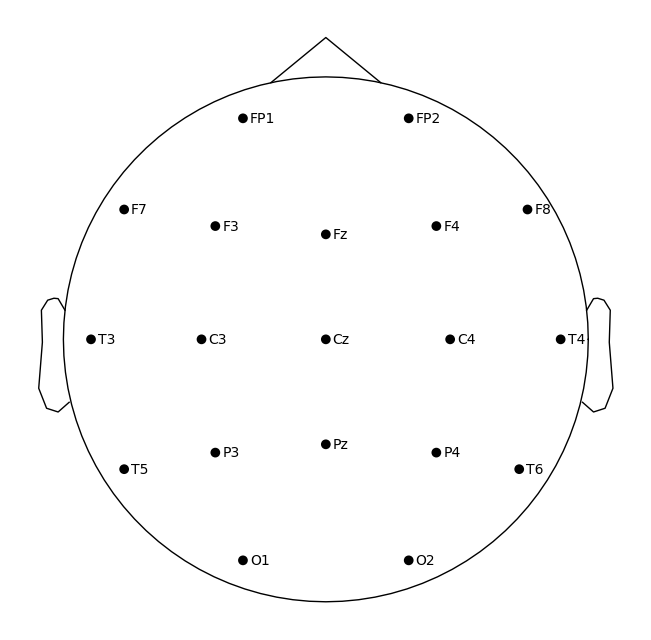

In [ ]:
import mne
import matplotlib.pyplot as plt
from mne.datasets import fetch_fsaverage

# Define EEG channel coordinates (example channels)
mtg_chan = {
    'FP1': [-0.03, 0.08, 0], 'FP2': [0.03, 0.08, 0],
    'F7': [-0.073, 0.047, 0], 'F3': [-0.04, 0.041, 0], 'Fz': [0, 0.038, 0],
    'F4': [0.04, 0.041, 0], 'F8': [0.073, 0.047, 0], 'T3': [-0.085, 0, 0],
    'C3': [-0.045, 0, 0], 'Cz': [0, 0, 0], 'C4': [0.045, 0, 0], 'T4': [0.085, 0, 0],
    'T5': [-0.073, -0.047, 0], 'P3': [-0.04, -0.041, 0], 'Pz': [0, -0.038, 0],
    'P4': [0.04, -0.041, 0], 'T6': [0.07, -0.047, 0], 'O1': [-0.03, -0.08, 0], 'O2': [0.03, -0.08, 0]
}

# Create MNE info object and montage
info = mne.create_info(list(mtg_chan.keys()), sfreq=500, ch_types='eeg')
montage = mne.channels.make_dig_montage(mtg_chan)
info.set_montage(montage)

# Create a plot of sensors overlaid on a head model (without using brain surface)
fig = mne.viz.plot_sensors(info, ch_type='eeg', show_names=True)

# Save the plot
fig.savefig('eeg_sensors_head_only.png', bbox_inches='tight', transparent=True)

# Display the plot (optional)
plt.show()


In [ ]:
# Define the classify function for training and evaluation
def classify(model, X_train, y_train, X_test, y_test):
    """Train model, make predictions, and print accuracy and classification report."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 40)

In [ ]:
# Define the function to extract feature importance for different types of models
def extract_fi(model):
    """Extract feature importance from the model if available."""
    if hasattr(model, 'coef_'):  # Linear models like LogisticRegression, SVM with linear kernel
        return model.coef_[0]
    elif hasattr(model, 'feature_importances_'):  # Tree-based models
        return model.feature_importances_
    else:
        print(f"No feature importance for model: {model.__class__.__name__}")
        return np.zeros(len(X.columns))  # Return zero importance if not available


In [ ]:
# Data preprocessing function to prepare AB and COH data
def prepare_data(data):
    """Preprocess data by dropping unnecessary columns and encoding target variable."""
    data = data.drop(columns=['sex', 'age', 'iq'])
    data['specific.disorder'] = data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
    X = data.drop('specific.disorder', axis=1)
    y = data['specific.disorder']
    return X, y

In [ ]:
X_ab, y_ab = prepare_data(AB_data)
X_ab_train, X_ab_test, y_ab_train, y_ab_test = train_test_split(X_ab, y_ab, test_size=0.3, random_state=42)

In [ ]:
X_coh, y_coh = prepare_data(COH_data)
X_coh_train, X_coh_test, y_coh_train, y_coh_test = train_test_split(X_coh, y_coh, test_size=0.3, random_state=42)

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Initialize models
models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=10000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVM": SVC(kernel="linear", random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale features for AB data
scaler_ab = StandardScaler()
X_ab_train_scaled = scaler_ab.fit_transform(X_ab_train)
X_ab_test_scaled = scaler_ab.transform(X_ab_test)

In [ ]:
# Scale features for COH data
scaler_coh = StandardScaler()
X_coh_train_scaled = scaler_coh.fit_transform(X_coh_train)
X_coh_test_scaled = scaler_coh.transform(X_coh_test)

In [ ]:
# Feature importance results storage
feature_importances = {}

In [ ]:
# Train and evaluate models, extract and store feature importance
for model_name, model in models.items():
    print(f"\nTraining on AB data with model: {model_name}")
    classify(model, X_ab_train_scaled, y_ab_train, X_ab_test_scaled, y_ab_test)
    
    # Extract feature importance for AB data
    fi_ab = extract_fi(model)
    feature_importances[model_name + " (AB)"] = pd.DataFrame({'Feature': X_ab.columns, 'Importance': fi_ab})
    
    print(f"\nTraining on COH data with model: {model_name}")
    classify(model, X_coh_train_scaled, y_coh_train, X_coh_test_scaled, y_coh_test)
    
    # Extract feature importance for COH data
    fi_coh = extract_fi(model)
    feature_importances[model_name + " (COH)"] = pd.DataFrame({'Feature': X_coh.columns, 'Importance': fi_coh})


Training on AB data with model: LogisticRegression

Training on COH data with model: LogisticRegression

Training on AB data with model: Random Forest

Training on COH data with model: Random Forest

Training on AB data with model: Linear SVM

Training on COH data with model: Linear SVM

Training on AB data with model: XGBoost

Training on COH data with model: XGBoost

Training on AB data with model: LightGBM
[LightGBM] [Info] Number of positive: 34, number of negative: 38
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Warning] No further spli

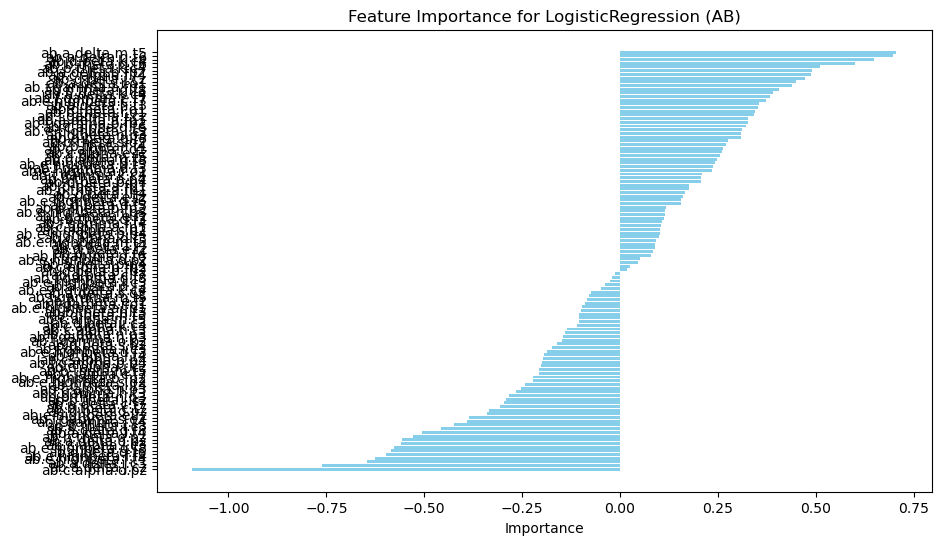

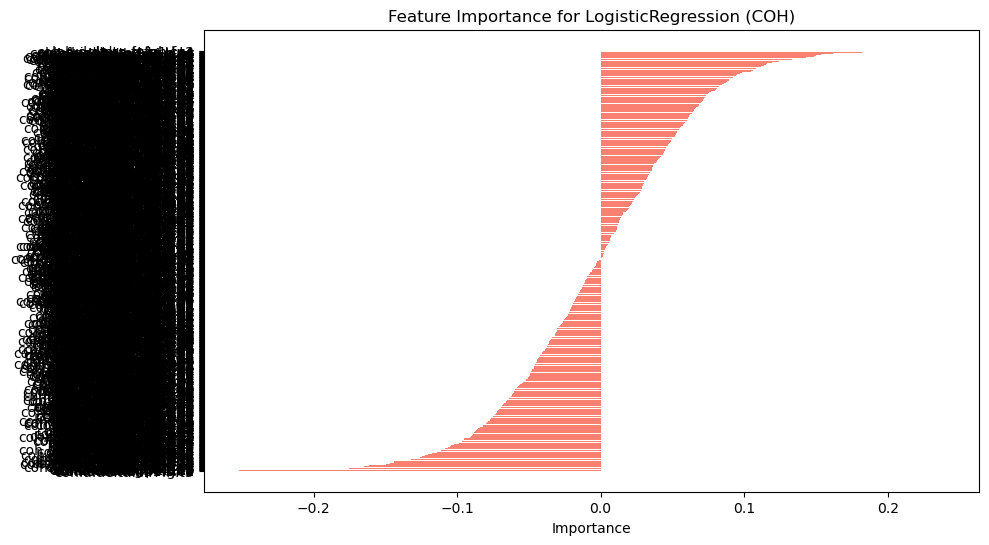

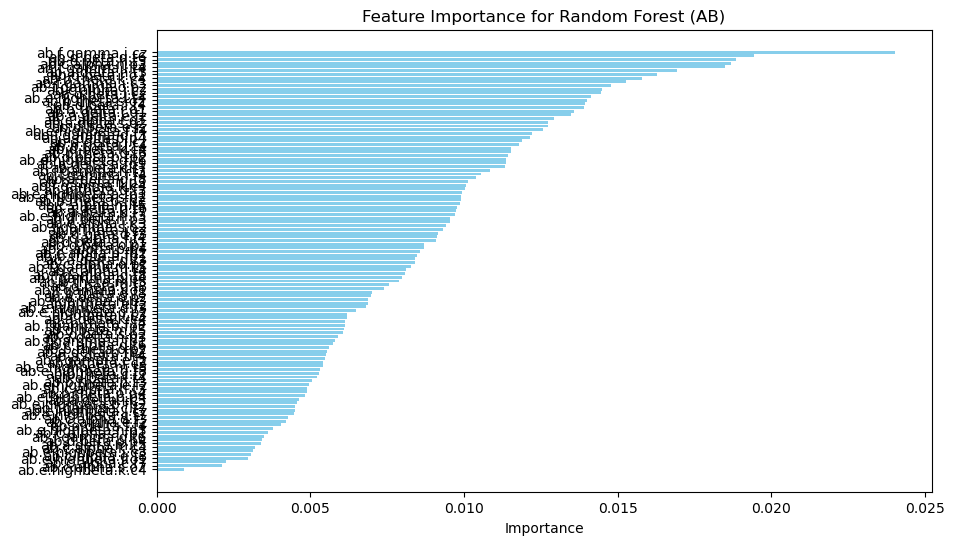

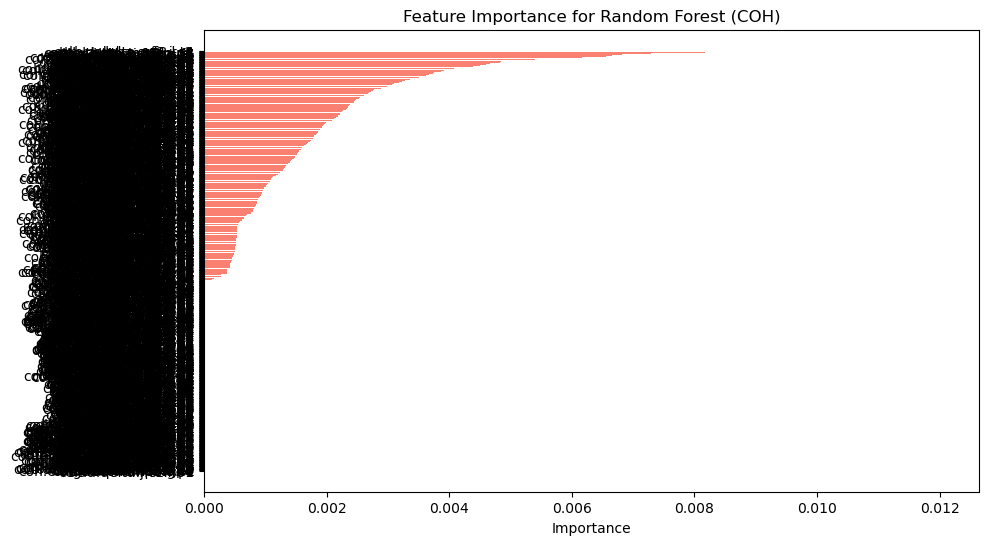

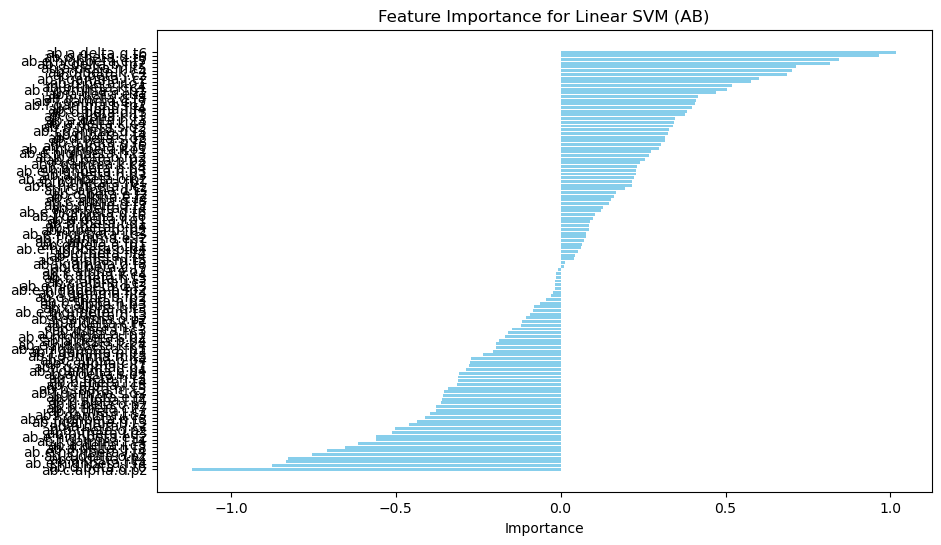

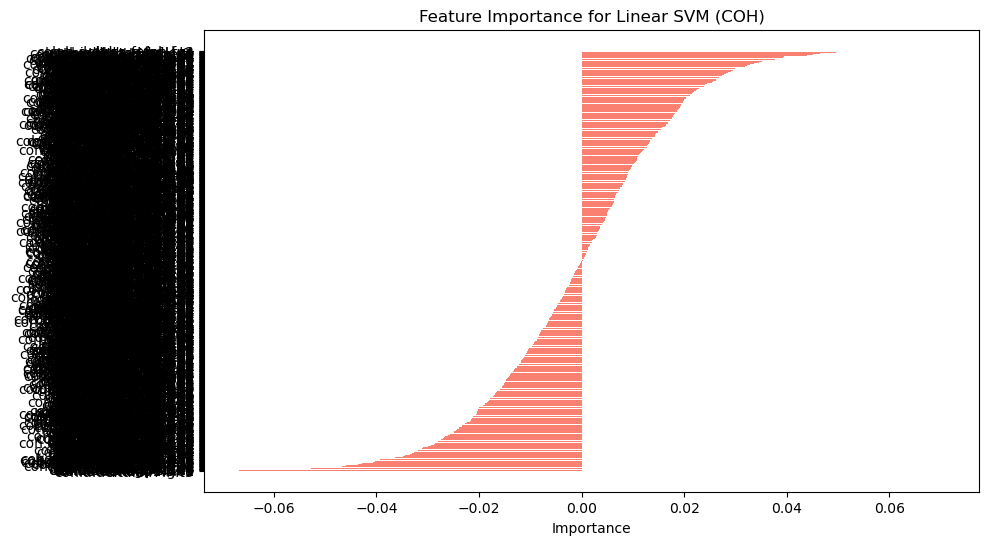

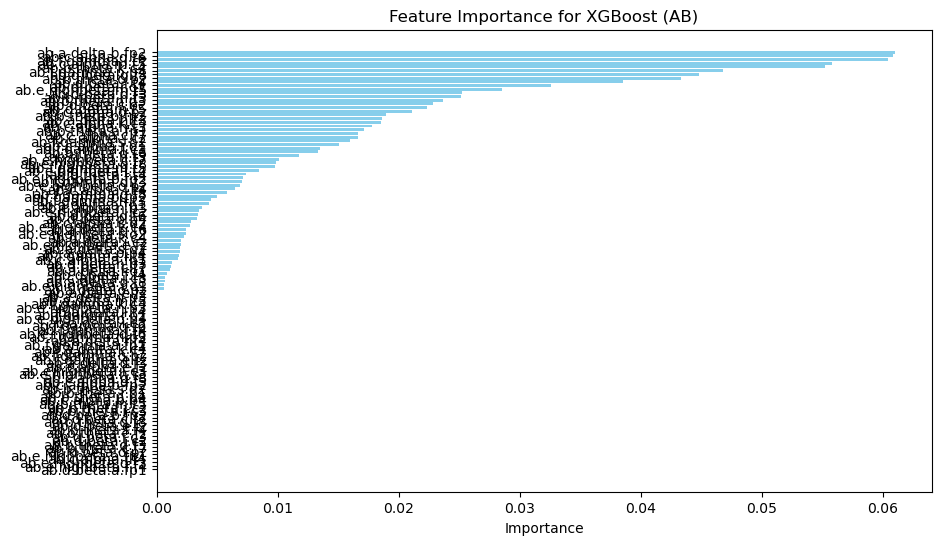

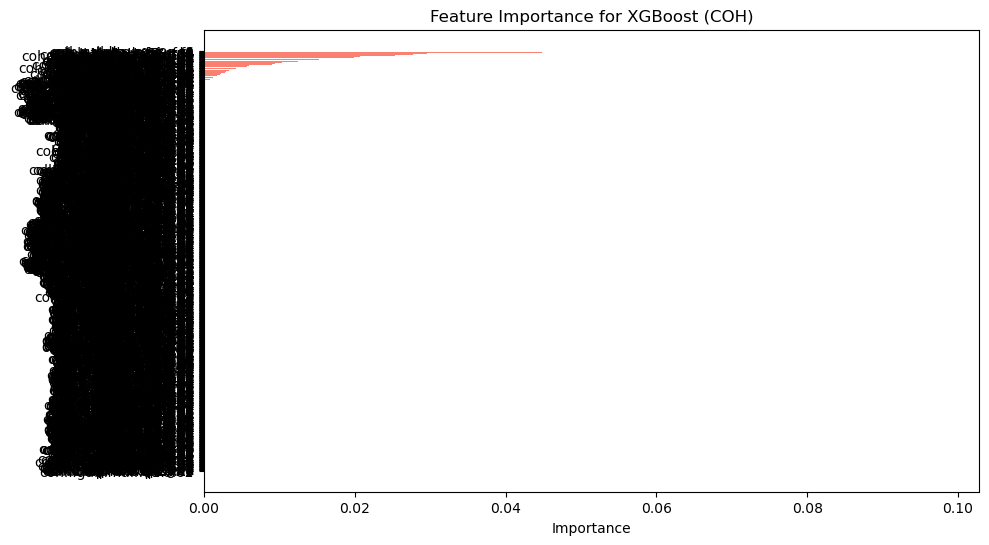

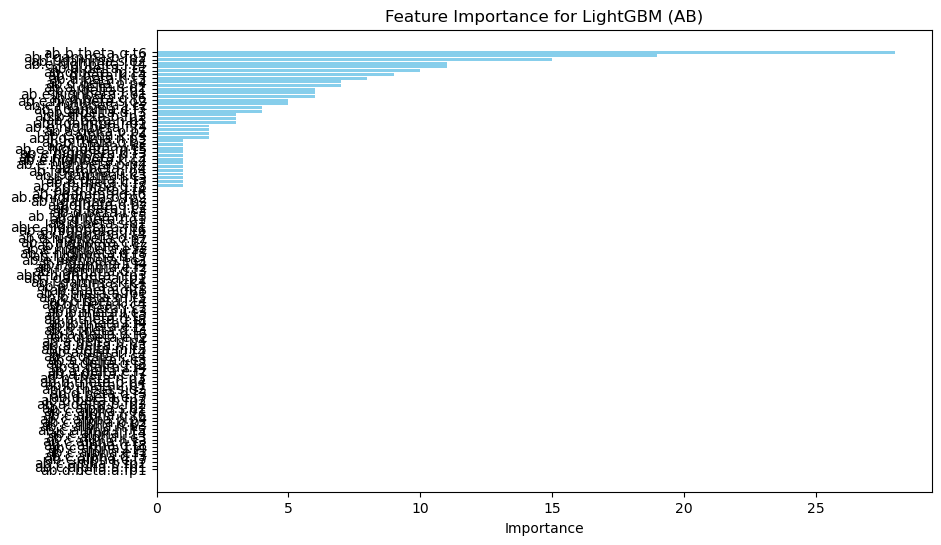

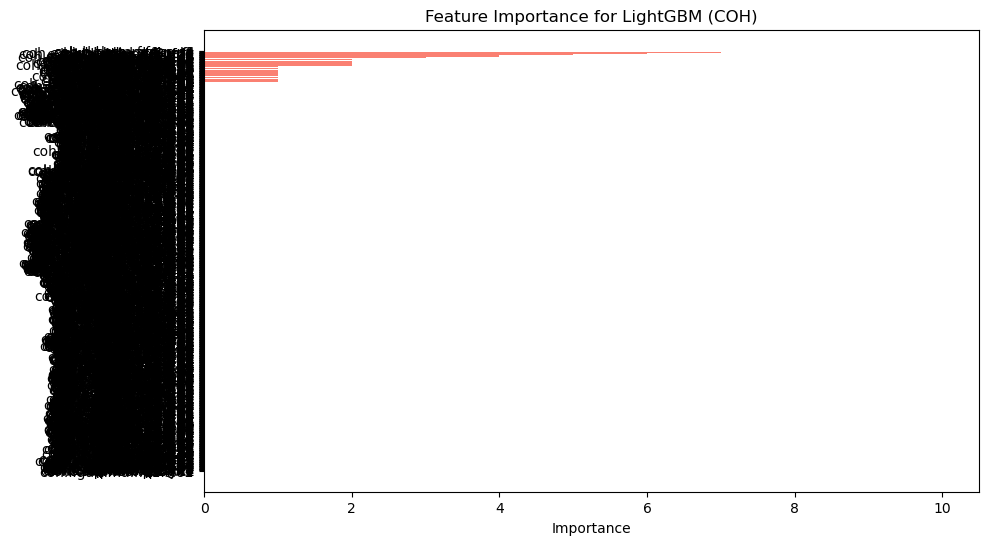

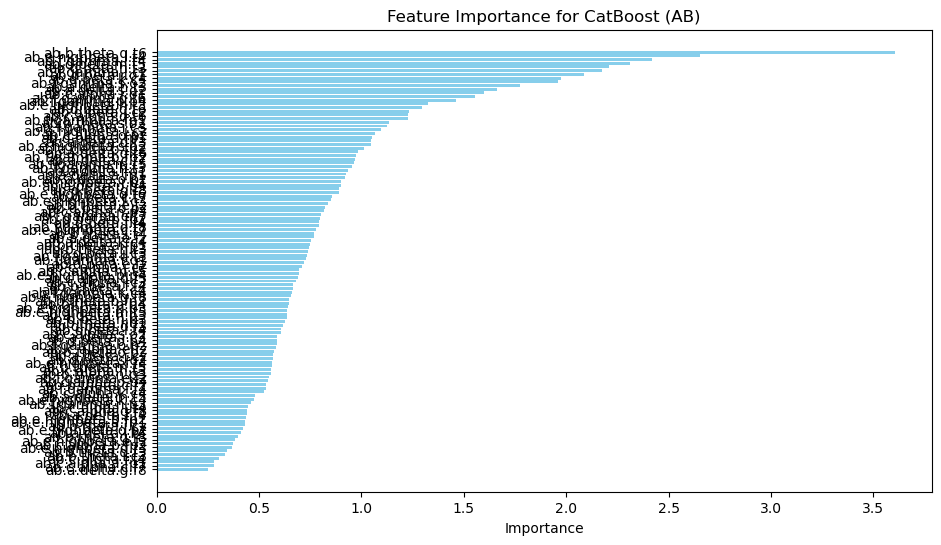

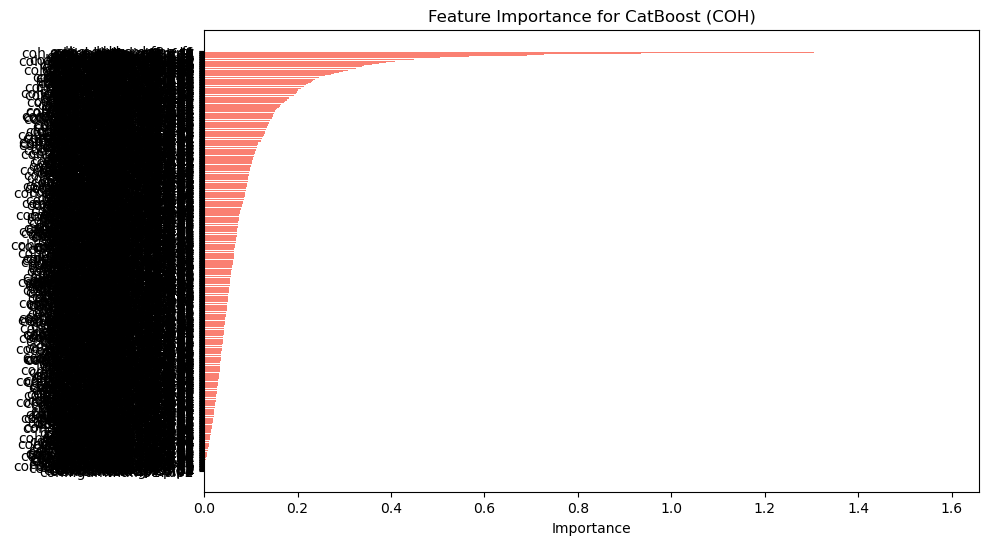

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance for each model
for model_key, fi_df in feature_importances.items():
    fi_df = fi_df.sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi_df['Feature'], fi_df['Importance'], color='skyblue' if "AB" in model_key else 'salmon')
    plt.xlabel("Importance")
    plt.title(f"Feature Importance for {model_key}")
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import patheffects

def barchart(table, x, heights, color=None, ax=None, palette=None, orient='h', xlab=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    if orient == 'v':
        barfunc = ax.bar
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)
        ax.set_xlabel(x)
        ax.set_ylabel(heights)
    else:
        barfunc = ax.barh
        ax.xaxis.grid(True)
        ax.yaxis.grid(False)
        ax.invert_yaxis()
        ax.set_ylabel(x)
        ax.set_xlabel(heights)
    if xlab is not None:
        ax.set_xlabel(xlab)
    if ylab is not None:
        ax.set_ylabel(ylab)
    if color is not None:
        colors = [palette[cat] for cat in table.feature_cat]
        patches = [mpatches.Patch(color=c, label=ftr_cat) for ftr_cat, c in palette.items()]
        ax.legend(patches, palette.keys())
    else:
        colors = None
    barfunc(table[x], table[heights], color=colors)        
    return ax


In [ ]:
def fi_viz(table, feature, feature_cat, importance, palette, figure=None, cat=True):
    if figure is None:
        figure = plt.figure()
    if cat:
        axes = figure.subplots(1, 2)
        cat_fi = table.groupby(feature_cat)[importance].sum().reset_index().sort_values(importance, ascending=False)
        barchart(cat_fi, feature_cat, importance, feature_cat, axes[1], palette, xlab='importance', ylab='feature category')
    else:
        axes = figure.subplots()
        axes = [axes]        
    barchart(table, feature, importance, feature_cat, axes[0], palette, xlab='importance')        
    return figure


In [ ]:
def fi_viz_eeg(table, palette, feature='feature', feature_cat='feature_cat', figure=None, ax=None, separate=True, img_path='head.png'):
    # Read background image for EEG head map
    im = plt.imread('head.png')
    if ax is not None:
        separate=False
    elif figure is None:
        figure = plt.figure()
    if separate:
        axes = figure.subplots(1, 2)
        ax_psd = axes[0]
        ax_coh = axes[1]
        axes[0].set_title('Power Spectral Density (PSD)')
        axes[1].set_title('Functional Connectivity (FC)')
    else:
        if ax is None:
            axes = figure.subplots()
        else:
            axes = ax
        ax_psd = axes
        ax_coh = axes
        axes = [axes]
    
    # Plot feature importance on EEG map
    ftrcat_channels = table.groupby(feature_cat)[feature].agg(','.join).transform(get_channels)
    for ftr_cat, channels_arr in ftrcat_channels.items():
        color = palette[ftr_cat]
        if 'PSD' in ftr_cat:
            x, y = get_coordinates(channels_arr)
            ax_psd.scatter(x, y, c=[color], s=plt.rcParams['lines.markersize'] ** 3.5, label=ftr_cat)
        else:
            for i, arr in enumerate(channels_arr):
                x, y = get_coordinates(arr)
                if i == 0:
                    lab = ftr_cat
                else:
                    lab = None
                ax_coh.plot(x, y, c=color, linewidth=12, label=lab)
                
    for txt in channels.index:
        for ax in axes:
            text = ax.text(channels.loc[txt, 0], channels.loc[txt, 1], txt, color='white', fontweight='extra bold',  
                           horizontalalignment='center', verticalalignment='center')
            text.set_path_effects([patheffects.withStroke(linewidth=3, foreground='black')])

    for ax in axes:
        ax.imshow(im, extent=[-1, 1, -1, 1])
        ax.axis('off')
        ax.margins(x=0, y=0)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.5, frameon=False)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import patheffects

# Define feature categories and palette
feature_category = [
    'delta PSD', 'delta FC', 'theta PSD', 'theta FC', 
    'alpha PSD', 'alpha FC', 'beta PSD', 'beta FC', 
    'highbeta PSD', 'highbeta FC', 'gamma PSD', 'gamma FC'
]

# Create a color palette for the categories
cmap = plt.get_cmap('tab20')
palette = {feature_category[i]: cmap.colors[i] for i in range(len(feature_category))}

# Define functions like barchart, fi_viz, fi_viz_eeg, etc. (use your existing ones)

def report_fi(res_tab, disorder, col='importance_sum', survival_thres=0.7, palette=palette, root_dir=None):  
    # Extract top features
    table = top_n(flatten_columns(summary_fi_table(res_tab)), survival_thres=survival_thres).reset_index()
    
    # Recreate palette with only relevant colors
    unq_cat = table['feature_cat'].unique()
    palette = {key: item for key, item in palette.items() if key in unq_cat}
    
    # Barchart for feature and category importance
    fig1 = plt.figure(tight_layout=True, figsize=(15, 5))
    fig1.suptitle(disorder)
    fi_viz(table, 'feature', 'feature_cat', col, palette, fig1)
    fig1.tight_layout()
    
    # Plot feature importance on EEG map
    fig2 = plt.figure(tight_layout=True, figsize=(15, 7))
    fi_viz_eeg(table, figure=fig2, palette=palette)
    fig2.tight_layout()
    
    # Save plots to files
    if root_dir is not None:
        save_dir = cache_mkdir(True, disorder.replace(' ', '_'), root_dir)
        img_path = os.path.join(save_dir, 'fi1.png')
        fig1.savefig(img_path, bbox_inches='tight')
        img_path = os.path.join(save_dir, 'fi2.png')
        fig2.savefig(img_path, bbox_inches='tight')


In [ ]:
ab_results = ab_model.feature_importances_  # Feature importances for AB data
coh_results = coh_model.feature_importances_  # Feature importances for COH data

In [ ]:
report_fi(ab_results, '1 (AB)', col='importance', palette=palette, root_dir='viz')
report_fi(coh_results, '1 (COH)', col='importance', palette=palette, root_dir='viz')

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define flatten_columns function
def flatten_columns(df):
    """
    Flatten hierarchical or multi-index columns in a DataFrame.
    """
    return df.columns.to_frame(index=False).reset_index(drop=True)

# Define summary_fi_table function
def summary_fi_table(res_tab, feature_names):
    """
    Summarize feature importance data.
    Convert the feature importances into a DataFrame.
    """
    return pd.DataFrame({'Feature': feature_names, 'Importance': res_tab})

# Define top_n function
def top_n(table, survival_thres=0.7):
    """
    Function to select the top N features based on importance threshold.
    """
    table = table[table['Importance'] >= survival_thres]
    return table

# Function to visualize the feature importance as a bar chart
def barchart(table, x, heights, color=None, ax=None, palette=None, orient='h', xlab=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    if orient == 'v':
        barfunc = ax.bar
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)
        ax.set_xlabel(x)
        ax.set_ylabel(heights)
    else:
        barfunc = ax.barh
        ax.xaxis.grid(True)
        ax.yaxis.grid(False)
        ax.invert_yaxis()
        ax.set_ylabel(x)
        ax.set_xlabel(heights)
    if xlab is not None:
        ax.set_xlabel(xlab)
    if ylab is not None:
        ax.set_ylabel(ylab)
    if color is not None:
        colors = [palette[cat] for cat in table.feature_cat]
        patches = [mpatches.Patch(color=c, label=ftr_cat) for ftr_cat, c in palette.items()]
        ax.legend(patches, palette.keys())
    else:
        colors = None
    barfunc(table[x], table[heights], color=colors)        
    return ax

# Visualization function for feature importance
def fi_viz(table, feature, feature_cat, importance, palette, figure=None, cat=True):
    if figure is None:
        figure = plt.figure()
    if cat:
        axes = figure.subplots(1, 2)
        cat_fi = table.groupby(feature_cat)[importance].sum().reset_index().sort_values(importance, ascending=False)
        barchart(cat_fi, feature_cat, importance, feature_cat, axes[1], palette, xlab='importance', ylab='feature category')
    else:
        axes = figure.subplots()
        axes = [axes]        
    barchart(table, feature, importance, feature_cat, axes[0], palette, xlab='importance')        
    return figure

# Visualization for EEG
def fi_viz_eeg(table,  palette, feature='feature', feature_cat='feature_cat', figure=None, ax=None, separate=True, img_path='head.png'):
    # Read background image
    im = plt.imread('head.png')
    if ax is not None:
        separate=False
    elif figure is None:
        figure = plt.figure()
    if separate:
        axes = figure.subplots(1, 2)
        ax_psd = axes[0]
        ax_coh = axes[1]
        axes[0].set_title('Power Spectral Density (PSD)')
        axes[1].set_title('Functional Connectivity (FC)')
    else:
        if ax is None:
            axes = figure.subplots()
        else:
            axes = ax
        ax_psd = axes
        ax_coh = axes
        axes = [axes]
    
    # Process and plot feature importance on EEG map
    ftrcat_channels = table.groupby(feature_cat)[feature].agg(','.join).transform(get_channels)
    for ftr_cat, channels_arr in ftrcat_channels.items():
        color = palette[ftr_cat]
        if 'PSD' in ftr_cat:
            x, y = get_coordinates(channels_arr)
            ax_psd.scatter(x, y, c=[color], s=plt.rcParams['lines.markersize'] ** 3.5, label=ftr_cat)
        else:
            for i, arr in enumerate(channels_arr):
                x, y = get_coordinates(arr)
                if i == 0:
                    lab = ftr_cat
                else:
                    lab = None
                ax_coh.plot(x, y, c=color, linewidth=12, label=lab)
                
    for txt in channels.index:
        for ax in axes:
            text = ax.text(channels.loc[txt, 0], channels.loc[txt, 1], txt, color='white', fontweight='extra bold',  
                           horizontalalignment='center', verticalalignment='center')
            text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

    for ax in axes:
        ax.imshow(im, extent=[-1, 1, -1, 1])
        ax.axis('off')
        ax.margins(x=0, y=0)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.5, frameon=False)

# Now, assuming `ab_results` and `coh_results` are already computed as feature importances:

# Step 1: Extract feature importances as pandas DataFrame
ab_results_df = pd.DataFrame(ab_results, columns=['Importance'])
coh_results_df = pd.DataFrame(coh_results, columns=['Importance'])

# You need to replace `feature_names` with the actual feature names, which should be the column names of your input data (X).
feature_names = X.columns  # Replace this with the actual feature names you used in your model

# Step 2: Prepare the Results for Visualization (convert to DataFrame)
ab_results_df['Feature'] = feature_names
coh_results_df['Feature'] = feature_names

# Step 3: Visualize the Feature Importance for AB data
report_fi(ab_results_df, 'Posttraumatic stress disorder (AB)', col='Importance', palette=palette, root_dir='viz')

# Step 4: Visualize the Feature Importance for COH data
report_fi(coh_results_df, 'Posttraumatic stress disorder (COH)', col='Importance', palette=palette, root_dir='viz')


ValueError: Length of values (1143) does not match length of index (114)

In [ ]:
# Ensure feature names are maintained
X_ab, y_ab = prepare_data(AB_data)
X_coh, y_coh = prepare_data(COH_data)

# Keep track of the feature names before scaling
ab_feature_names = X_ab.columns  # Save the column names before scaling
coh_feature_names = X_coh.columns  # Save the column names before scaling

# Standardize the data
scaler = StandardScaler()
X_ab_scaled = scaler.fit_transform(X_ab)
X_coh_scaled = scaler.fit_transform(X_coh)

# Train RandomForest model for AB data
ab_model = RandomForestClassifier(n_estimators=100, random_state=42)
ab_model.fit(X_ab_scaled, y_ab)

# Train RandomForest model for COH data
coh_model = RandomForestClassifier(n_estimators=100, random_state=42)
coh_model.fit(X_coh_scaled, y_coh)

# Step 1: Extract Feature Importances from Trained Models
ab_results = ab_model.feature_importances_  # Feature importances for AB data
coh_results = coh_model.feature_importances_  # Feature importances for COH data

# Check the number of features in your X data (input to the model)
print("Number of features in X (AB data):", X_ab_scaled.shape[1])  # Should match length of ab_results
print("Number of features in X (COH data):", X_coh_scaled.shape[1])  # Should match length of coh_results

# Ensure the lengths of feature importances match the number of features
if len(ab_results) != X_ab_scaled.shape[1]:
    raise ValueError(f"Length of feature importances ({len(ab_results)}) does not match number of features ({X_ab_scaled.shape[1]})")

if len(coh_results) != X_coh_scaled.shape[1]:
    raise ValueError(f"Length of feature importances ({len(coh_results)}) does not match number of features ({X_coh_scaled.shape[1]})")

# Convert feature importances to pandas DataFrames with correct feature names
ab_results_df = pd.DataFrame({'Feature': ab_feature_names, 'Importance': ab_results})
coh_results_df = pd.DataFrame({'Feature': coh_feature_names, 'Importance': coh_results})

# Now, you can proceed with the visualization functions as before:
# Step 2: Visualize the Feature Importance for AB data
report_fi(ab_results_df, 'Posttraumatic stress disorder (AB)', col='Importance', palette=palette, root_dir='viz')

# Step 3: Visualize the Feature Importance for COH data
report_fi(coh_results_df, 'Posttraumatic stress disorder (COH)', col='Importance', palette=palette, root_dir='viz')


Number of features in X (AB data): 114
Number of features in X (COH data): 1026


TypeError: summary_fi_table() missing 1 required positional argument: 'feature_names'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches
import os

            Feature  Importance
0  ab.a.delta.a.fp1    0.006059
1  ab.a.delta.b.fp2    0.009399
2   ab.a.delta.c.f7    0.004169
3   ab.a.delta.d.f3    0.005226
4   ab.a.delta.e.fz    0.005427
                   Feature  Importance
0  coh.a.delta.a.fp1.b.fp2    0.002469
1   coh.a.delta.a.fp1.c.f7    0.008391
2   coh.a.delta.a.fp1.d.f3    0.004414
3   coh.a.delta.a.fp1.e.fz    0.001950
4   coh.a.delta.a.fp1.f.f4    0.007099
Top features selected (threshold 0.1): 0
Top features selected (threshold 0.1): 0


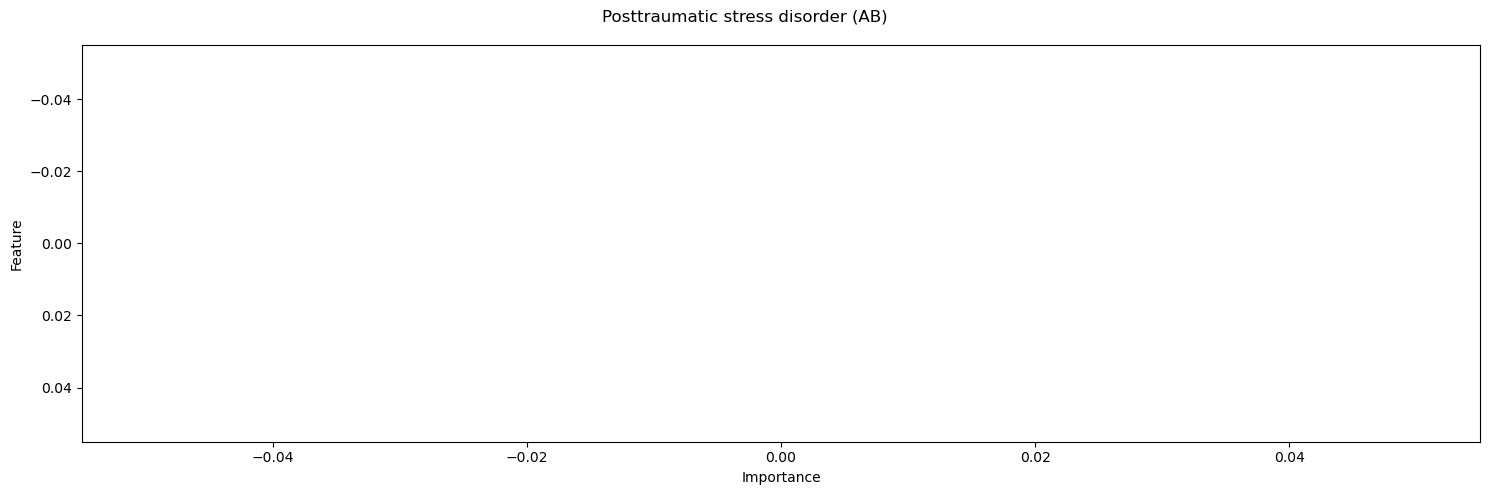

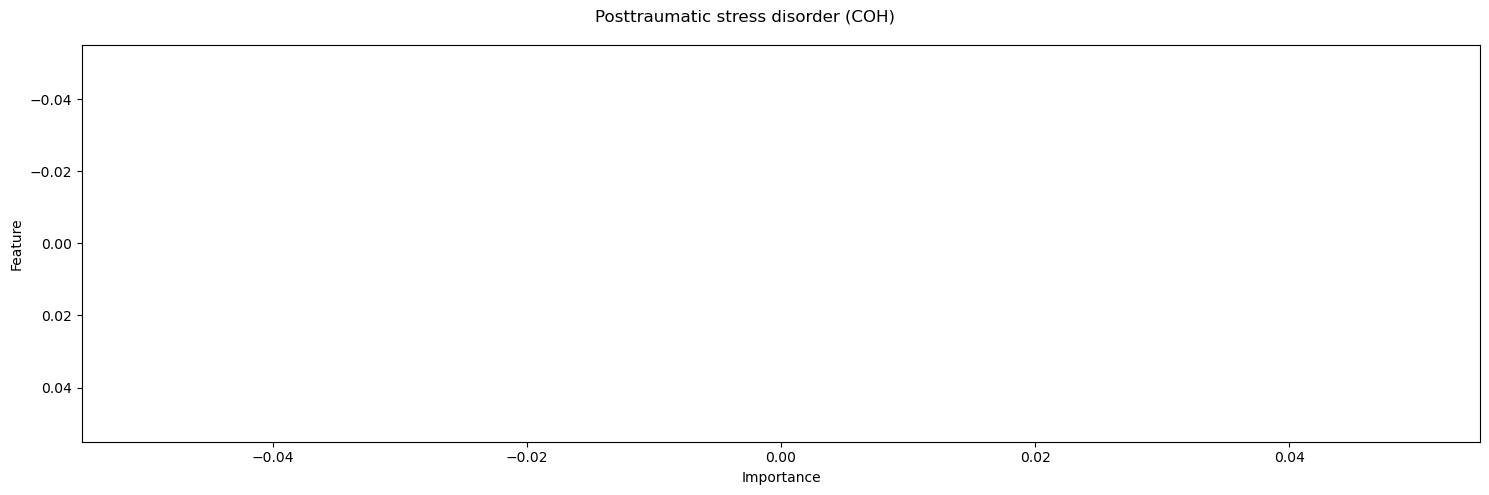

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import os

# Assuming AB_data and COH_data are already loaded
# Example:
# AB_data = pd.read_csv('AB_data.csv')
# COH_data = pd.read_csv('COH_data.csv')

# Example function to split data and prepare features
def prepare_data(data):
    """Preprocess data by dropping unnecessary columns and encoding target variable."""
    data = data.drop(columns=['sex', 'age', 'iq'])  # Modify according to your data
    data['specific.disorder'] = data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
    X = data.drop('specific.disorder', axis=1)
    y = data['specific.disorder']
    return X, y

# Prepare AB_data and COH_data
X_ab, y_ab = prepare_data(AB_data)
X_coh, y_coh = prepare_data(COH_data)

# Save feature names before scaling
ab_feature_names = X_ab.columns  # Save the column names before scaling
coh_feature_names = X_coh.columns  # Save the column names before scaling

# Standardize the data
scaler = StandardScaler()
X_ab_scaled = scaler.fit_transform(X_ab)
X_coh_scaled = scaler.fit_transform(X_coh)

# Train RandomForest model for AB data
ab_model = RandomForestClassifier(n_estimators=100, random_state=42)
ab_model.fit(X_ab_scaled, y_ab)

# Train RandomForest model for COH data
coh_model = RandomForestClassifier(n_estimators=100, random_state=42)
coh_model.fit(X_coh_scaled, y_coh)

# Step 1: Extract Feature Importances from Trained Models
ab_results = ab_model.feature_importances_  # Feature importances for AB data
coh_results = coh_model.feature_importances_  # Feature importances for COH data

# Convert feature importances to pandas DataFrames with correct feature names
ab_results_df = pd.DataFrame({'Feature': ab_feature_names, 'Importance': ab_results})
coh_results_df = pd.DataFrame({'Feature': coh_feature_names, 'Importance': coh_results})

# Check if DataFrames are populated correctly
print(ab_results_df.head())  # Check top 5 rows of AB results
print(coh_results_df.head())  # Check top 5 rows of COH results

# Step 2: Define top_n function to select top features based on importance threshold
def top_n(table, survival_thres=0.1):  # Lower the threshold to debug
    """Function to select the top N features based on importance threshold."""
    table = table[table['Importance'] >= survival_thres]
    print(f"Top features selected (threshold {survival_thres}): {len(table)}")  # Debug line
    return table

# Step 3: Define Visualization Functions (simplified)
def barchart(table, x, heights, ax=None, orient='h'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    table = table.sort_values(by=heights, ascending=False)  # Sort values by importance
    ax.barh(table[x], table[heights])
    ax.invert_yaxis()  # Highest importance on top
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    return ax

# Visualization function for feature importance
def fi_viz(table, feature, importance, figure=None):
    if figure is None:
        figure = plt.figure()
    axes = figure.subplots()
    barchart(table, feature, importance, ax=axes)
    return figure

# Function to report the feature importance (visualization)
def report_fi(res_tab, disorder, col='Importance', survival_thres=0.1, root_dir=None):  
    # Extract top features
    table = top_n(res_tab, survival_thres=survival_thres).reset_index(drop=True)
    
    # Plot feature importance for AB data
    fig1 = plt.figure(tight_layout=True, figsize=(15, 5))
    fig1.suptitle(disorder)
    fi_viz(table, 'Feature', col, fig1)
    fig1.tight_layout()

    # Save figures if root_dir is provided
    if root_dir is not None:
        save_dir = os.path.join(root_dir, disorder.replace(' ', '_'))
        os.makedirs(save_dir, exist_ok=True)
        img_path = os.path.join(save_dir, 'fi1.png')
        fig1.savefig(img_path, bbox_inches='tight')

# Step 4: Visualize the Feature Importance for AB data
palette = "viridis"  # You can choose other palettes like 'Set2', 'Blues', etc.
report_fi(ab_results_df, 'Posttraumatic stress disorder (AB)', col='Importance', root_dir='viz')

# Step 5: Visualize the Feature Importance for COH data
report_fi(coh_results_df, 'Posttraumatic stress disorder (COH)', col='Importance', root_dir='viz')
